# ML Fondamentals - MLDM & DSC first year Master 
## Support Vector Machines & Kernel


## Support Vector Machines (SVM)

We start by (trying... to) install a module that allows better visualization than the basic matplotlib:

In [1]:
!pip3 install seaborn --user

## First part: getting started with SVMs
This part is freely inspired by the work of Jake VenderPlas, author of the book [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do). His [GitHub](https://github.com/jakevdp/PythonDataScienceHandbook) is full of useful files.

First, we will generate toy data, linearly separable:

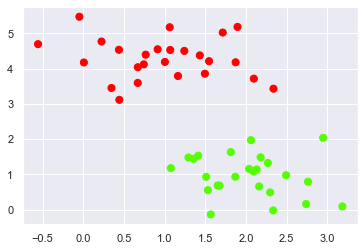

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

#a nice environment for bette plots
import seaborn as sns; sns.set()

# sklearn function to generate simple artificial data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

# Plot
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism');

### Linear SVM (=wide margin perceptron)
We will start by learning a kernelless SVM (we say "linear") using scikit-learn:

In [2]:
#import of the module - that is called SVC and nit SVM...
from sklearn.svm import SVC

model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

We are going to use a display function which is fine, where everything that is necessary is displayed. It does not necessarily have to be completely understood right away because we will come back to the important points below.

In [3]:
import numpy as np

def show_decision_function(model, ax=None, plot_support=True):
    """Plot the separator, the margins, and the support vectors of a SVM in 2D"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create a grid for evaluation
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot hyperplane and margins 
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolor='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Let's see what this looks like on our wide-margin linear separator:

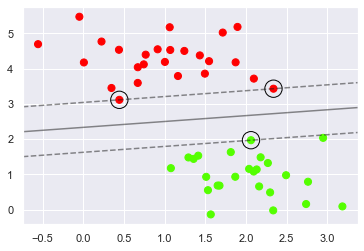

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism')
show_decision_function(model);

On this graph, we see the separator (solid line), the support vectors (circled points) and the margin (materialized by broken lines).
Here we have the separator that maximizes the margin.
Scikit-learn allows us, after learning, to retrieve the support vectors:

In [6]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Only three data are useful for classifying new data. We can ensure this by adding data without changing the model:

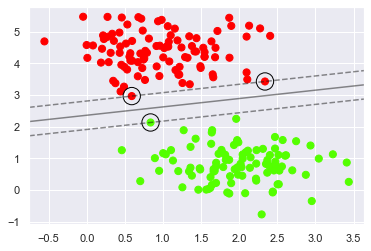

In [7]:
X2, y2 = make_blobs(n_samples=200, centers=2,
                  random_state=0, cluster_std=0.60)

model2 = SVC(kernel='linear', C=1E10)
model2.fit(X2, y2)

plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='prism')
show_decision_function(model2);

### Nonlinear SVM
As we saw during the course, the power of linear separators is limited (to linearly separable data). But it is possible to work around this limitation by using kernels.

We will start by generating non-linearly separable data:

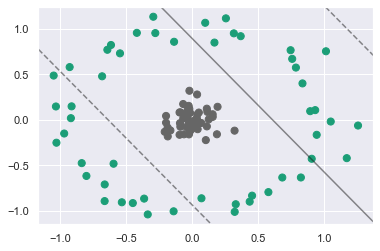

In [8]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='Dark2')
show_decision_function(clf, plot_support=False)

Clearly our linear separator learning failed...

We will manually add a third dimension *z*:

In [9]:
z = np.exp(-(X ** 2).sum(1))

We can display the augmented data and realize that they are linearly separable:

Text(0.5, 0, 'z')

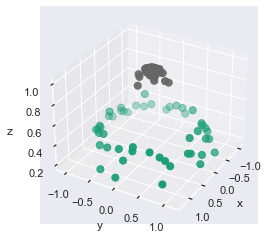

In [10]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], z, c=y, s=50, cmap='Dark2')
ax.view_init(elev=30, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

The plan defined by z=0.7 (for example) separates the 2 classes perfectly.

Of course, the projection in higher dimension is essential, and by choosing another calculation for *z* we would have obtained in most cases nonlinearly separable data.

And if it were actually necessary to make the projection, that would drastically limit the dimension of the embedding space as well as the number of data that can be processed. This is why the use of kernels is very efficient.

In Scikit-Learn, it is enough to modify the parameter *kernel*: until now, we used 'linear' as value. We can for example use *rbf* for 'radial basis function', the Gaussian kernel, and we still have to find the right value of the parameter:

In [11]:
clf = SVC(kernel='rbf', gamma='auto', C=1E10)
clf.fit(X, y)

SVC(C=10000000000.0, gamma='auto')

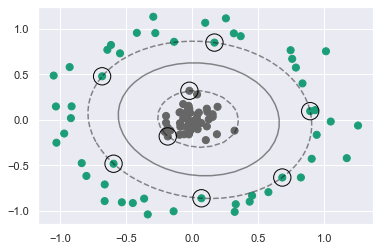

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='Dark2')
show_decision_function(clf) 

We see here that the separator (and the associated margin) are not linear in the data space, but that they can be represented there without difficulty.

Note also that the number of support vectors remains very small.

### Soft Margin SVM

It is also possible that the problem is linearly separable (in the initial dimension of the data or in an embedding) but that the noise (= the poor quality of the data) prevents the learner from finding a separator.

We then use what is called a soft-margin classifier: we then allow certain points to be in the margin. This is the role of the *C* parameter: for large values, we are almost at a hard margin, but the smaller *C* value is, the more the margins become permissible.

We will take data that overlaps a little:

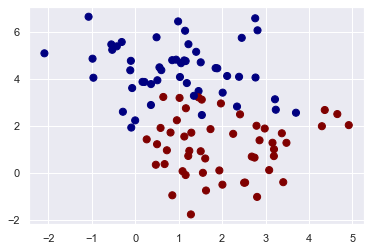

In [13]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet');

We then play with the value of *C*

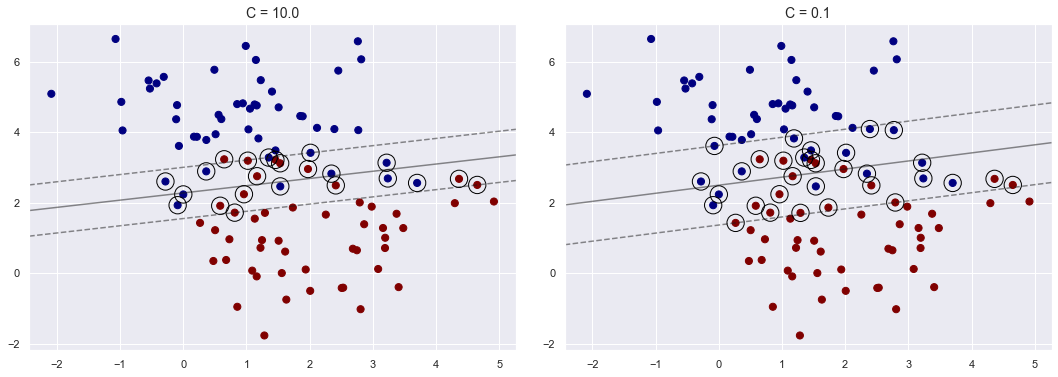

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
    show_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Of course, it is possible to combine the use of a kernel and soft margins.

### Tuning an SVM
All kernels are parameterized: the question here is about studying the impact of a (hyper)parameter on the quality of learning.
We will generate data that are not linearly separable:

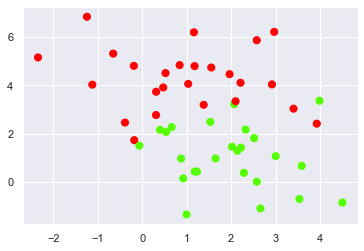

In [15]:
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=1.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism')

We will study 2 different kernels
- the polynomial kernel (*kernel='poly'*) which has 2 parameters, *degree* which must be varied between 2 and 6 (at least), and *C* (related to the 'softness' of the margin)
- the Gaussian kernel (*kernel='rbf'*) which also has 2 parameters,*gamma*, which must be varied from 1 to 0.01, and*C*

Each time, in addition to the display of the separators, it would be interesting to look at how many support vectors the learned classifier needs.

Up to you !

degree =  2
support_vectors_ =  10
degree =  3
support_vectors_ =  6
degree =  4
support_vectors_ =  11
degree =  5
support_vectors_ =  7
degree =  6
support_vectors_ =  8


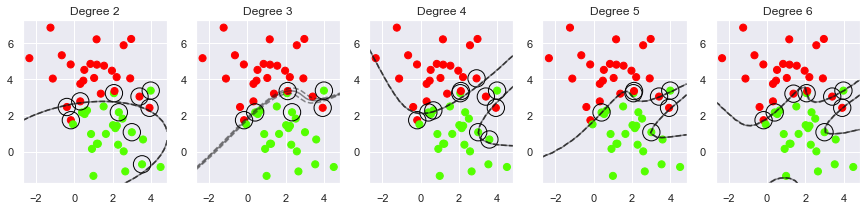

In [16]:
# Your turn

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# On affiche les points
for ax in axs:
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism')

# On fait tourner le kernel poly de degree 2 a 6 avec 1E10
for deg, ax in zip(range(2, 7), axs):
    print("degree = ", deg)
    model1 = SVC(kernel='poly', degree=deg, C=1E10)
    model1.fit(X, y)
    show_decision_function(model1, ax=ax)
    ax.set_title(f"Degree {deg}")
    print("support_vectors_ = ", len(model1.support_vectors_))


gamma =  0.01
support_vectors_ =  7
gamma =  0.2575
support_vectors_ =  12
gamma =  0.505
support_vectors_ =  18
gamma =  0.7525
support_vectors_ =  21
gamma =  1.0
support_vectors_ =  26


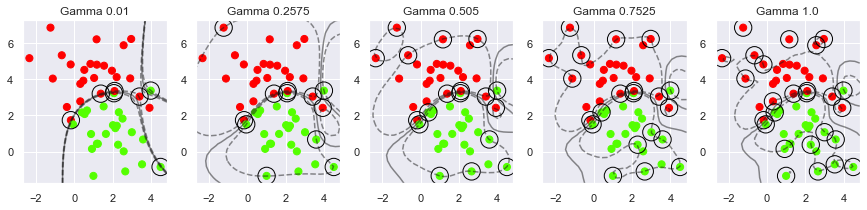

In [17]:
###

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# On affiche les points
for ax in axs:
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism')

# On fait tourner le kernel poly de degree 2 a 6 avec 1E10
for gam, ax in zip(np.linspace(0.01, 1, 5), axs):
    print("gamma = ", gam)
    model1 = SVC(kernel='rbf', gamma=gam, C=1E10)
    model1.fit(X, y)
    show_decision_function(model1, ax=ax)
    ax.set_title(f"Gamma {gam}")
    print("support_vectors_ = ", len(model1.support_vectors_))


## Second part: an (almost) complete treatment
### Data Preparation
We will use a real dataset - taken from *Tsanas & Xifara: Accurate quantitative estimation of energy performance of residential buildings using statistical machine learning tools, Energy and Buildings, Vol. 49, p. 560-567, 2012* - which you need to download first:

In [18]:
!wget https://remieyraud.github.io/data.csv

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


The first 8 columns are descriptive attributes and the last two are heating and cooling loads (in that order).
To use them in Python, you can use the following code:

In [6]:
data = np.loadtxt("./data.csv")
X = data[:,:-2]
Y = data[:,-2:]
Yheat = Y[:,0]
Ycool = Y[:,1]

The original problem, as presented here, is a regression problem. We will first turn it into a classification problem. Using a clustering method, we want to divide the heating and cooling loads into 3 classes: low, medium, high.

Up to you :

In [7]:
# What's next ? We want to define a k-means classifier with k=3
from sklearn.cluster import KMeans

# What's next ? We want to define a k-means classifier with k=3
my_classifierCool = KMeans(n_clusters=3, init='k-means++')
my_classifierHeat = KMeans(n_clusters=3, init='k-means++')

#then use "fit"  on the 2 sets of potential Y values
Yheat_reshaped = Yheat.reshape(-1,1)
Ycool_reshaped = Ycool.reshape(-1,1)

# 2 classifiers, one for each Y
my_classifierHeat.fit(Yheat_reshaped)
my_classifierCool.fit(Ycool_reshaped)

# The only trick: the Y are vectors while sklearn classifiers need arrays:
# you need to reshape them: Yheat_array = Yheat.reshape(-1,1)

# After the training, assigned classes are stored in my_classifier.labels_

print(my_classifierHeat.labels_)
print(my_classifierCool.labels_)







[0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 1 1 1 1
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 1 1 1 1 2 2 2 2
 2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 2 2 2 1 1 1 1 2 2 2 2 2 

### Apprentissage
Nous voulons comparer plusieurs méthodes d'apprentissage :
1. Les k-plus proches voisins (*KNeighborsClassifier* de la classe *sklearn.neighbors*, hyperparamètre à régler : *n_neighbors*)
2. Les arbres de décision  (*DecisionTreeClassifier* de la classe *sklearn.tree*, hyperparamètre à régler : *max_depth*)
3. Perceptron linéaire (*Perceptron* de la classe *sklearn.linear_model*, hyperparamètre à régler : aucun/*max_iter* en sklearn 0.19 ou plus récent)
4. SVM à noyau gaussien  (*SVC* avec *kernel='rbf'* de la classe *sklearn.svm*, hyperparamètre à régler : *gamma*)
5. SVM à noyau polynomial (*SVC* avec *kernel='poly'* de la classe *sklearn.svm*, hyperparamètre à régler : *degree*)

Ecrivez le code permettant de :
1. Séparer les données en un échantillon d'apprentissage et un échantillon de test (80/20)
2. Sélectionner les meilleurs valeurs des hyperparamètres sur l'échantillon d'apprentissage par validation croisée en utilisant 10 folders

### Learning
We want to compare several learning methods:
1. K-nearest neighbors (*KNeighborsClassifier* of class *sklearn.neighbors*, hyperparameter to tune: *n_neighbors*)
2. Decision trees (*DecisionTreeClassifier* of class *sklearn.tree*, hyperparameter to tune: *max_depth*)
3. Gaussian Kernel SVM (*SVC* with *kernel='rbf'* of class *sklearn.svm*, hyperparameter to tune: *gamma* )
4. Polynomial kernel SVM (*SVC* with *kernel='poly'* of class *sklearn.svm*, hyperparameter to set: *degree* )

Write code to:
1. Separate the data into a training sample and a test sample (80/20)
2. Select the best values ​​of the hyperparameters on the training sample by cross-validation using 10 folders

In [14]:

# Import des librairies
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
# Numpy pour la fonction "logspace()"" pour définir les valeurs de "gamma"
import numpy as np

# Séparation des données en ensemble d'apprentissage et ensemble de test
X_train, X_test, y_trainCool, y_testCool, y_trainHeat, y_testHeat = train_test_split(X, my_classifierCool.labels_, my_classifierHeat.labels_, test_size=0.2, random_state=42)

# Définition des listes de paramètres à tester pour chaque modèle, on reprend ceux du TP n°2 et de ce TP juste avant
knn_param_grid = {'n_neighbors': list(range(1, 15))}
dt_param_grid = {'max_depth': list(range(5, 21))}
svc_param_grid = {'gamma': list(np.linspace(0.01, 1, 5))}
poly_svc_param_grid = {'degree': list(range(2, 7))}
# Ici vue que l'ont a jamais traiter le "hyperparamètre" max_iter, j'ai fait des test mais j'ai eu que des erreurs. Je met donc a sa valeur par défaut : 1000
perceptron_param_grid = {'max_iter': [1000]}

# Initialisation des modèles
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
svc = SVC(kernel='rbf')
poly_svc = SVC(kernel='poly')
perceptron = Perceptron()

# Définition des grilles de recherche de paramètres pour chaque modèle (CrossValidation)
knn_grid_search_Cool = GridSearchCV(knn, knn_param_grid, cv=10)
dt_grid_search_Cool = GridSearchCV(dt, dt_param_grid, cv=10)
svc_grid_search_Cool = GridSearchCV(svc, svc_param_grid, cv=10)
poly_svc_grid_search_Cool = GridSearchCV(poly_svc, poly_svc_param_grid, cv=10)
perceptron_grid_search_Cool = GridSearchCV(perceptron, perceptron_param_grid, cv=10)

# Recherche des meilleurs paramètres pour chaque modèle sur l'ensemble d'apprentissage Cool
knn_grid_search_Cool.fit(X_train, y_trainCool)
dt_grid_search_Cool.fit(X_train, y_trainCool)
svc_grid_search_Cool.fit(X_train, y_trainCool)
poly_svc_grid_search_Cool.fit(X_train, y_trainCool)
perceptron_grid_search_Cool.fit(X_train, y_trainCool)

# Affichage des meilleurs paramètres pour chaque modèle
print("\nCOOL")
print("KNN : ", knn_grid_search_Cool.best_params_)
print("DT : ", dt_grid_search_Cool.best_params_)
print("SVC : ", svc_grid_search_Cool.best_params_)
print("Poly SVC : ", poly_svc_grid_search_Cool.best_params_)
print("Perceptron : ", perceptron_grid_search_Cool.best_params_)

# Définition des grilles de recherche de paramètres pour chaque modèle (CrossValidation)
knn_grid_search_Heat = GridSearchCV(knn, knn_param_grid, cv=10)
dt_grid_search_Heat = GridSearchCV(dt, dt_param_grid, cv=10)
svc_grid_search_Heat = GridSearchCV(svc, svc_param_grid, cv=10)
poly_svc_grid_search_Heat = GridSearchCV(poly_svc, poly_svc_param_grid, cv=10)
perceptron_grid_search_Heat = GridSearchCV(perceptron, perceptron_param_grid, cv=10)

# Recherche des meilleurs paramètres pour chaque modèle sur l'ensemble d'apprentissage Heat
knn_grid_search_Heat.fit(X_train, y_trainHeat)
dt_grid_search_Heat.fit(X_train, y_trainHeat)
svc_grid_search_Heat.fit(X_train, y_trainHeat)
poly_svc_grid_search_Heat.fit(X_train, y_trainHeat)
perceptron_grid_search_Heat.fit(X_train, y_trainHeat)

# Affichage des meilleurs paramètres pour chaque modèle
print("\nHEAT")
print("KNN : ", knn_grid_search_Heat.best_params_)
print("DT : ", dt_grid_search_Heat.best_params_)
print("SVC : ", svc_grid_search_Heat.best_params_)
print("Poly SVC : ", poly_svc_grid_search_Heat.best_params_)
print("Perceptron : ", perceptron_grid_search_Heat.best_params_)




COOL
KNN :  {'n_neighbors': 4}
DT :  {'max_depth': 18}
SVC :  {'gamma': 0.01}
Poly SVC :  {'degree': 2}
Perceptron :  {'max_iter': 1000}

HEAT
KNN :  {'n_neighbors': 3}
DT :  {'max_depth': 7}
SVC :  {'gamma': 0.7525}
Poly SVC :  {'degree': 6}
Perceptron :  {'max_iter': 1000}


### Results analysis
Display on a curve the scores of each of the algorithms with the best possible hyperparameter value on the test sample.

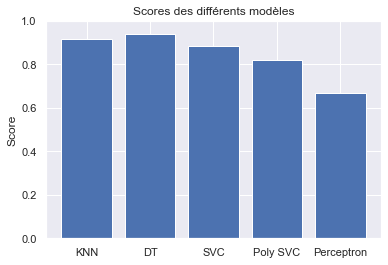

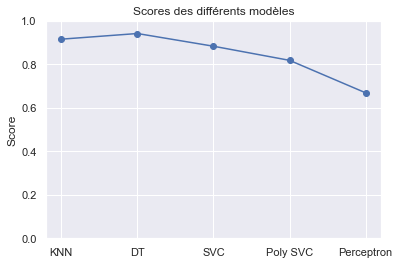

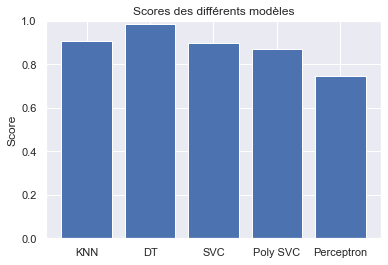

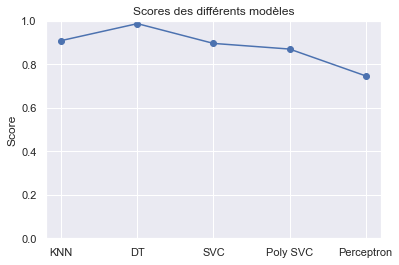

In [15]:
import matplotlib.pyplot as plt

# Pour chaque modèle, on récupère le score du meilleur modèle sur l'ensemble de test pour le tracer ensuite
# Bien sur, il s'agit du meilleur hyperparamètre trouvé juste avant pour chaque algorithmes
#################### ON TEST AVEC LES COOL ####################
knn_score = knn_grid_search_Cool.best_estimator_.score(X_test, y_testCool)
dt_score = dt_grid_search_Cool.best_estimator_.score(X_test, y_testCool)
svc_score = svc_grid_search_Cool.best_estimator_.score(X_test, y_testCool)
poly_svc_score = poly_svc_grid_search_Cool.best_estimator_.score(X_test, y_testCool)
perceptron_score = perceptron_grid_search_Cool.best_estimator_.score(X_test, y_testCool)

# On crée un dictionnaire pour stocker le score de chaque modèle
scores = {'KNN': knn_score, 'DT': dt_score, 'SVC': svc_score, 'Poly SVC': poly_svc_score, 'Perceptron': perceptron_score}

# On affiche les scores des différents modèles sur un graphique en barres
fig, ax = plt.subplots()
ax.bar(scores.keys(), scores.values())
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Scores des différents modèles')

# On affiche le graphique
plt.show()

# On affiche les scores des différents modèles sur un graphique en courbe
fig, ax = plt.subplots()
ax.plot(scores.keys(), scores.values(), marker='o')
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Scores des différents modèles')

# On affiche le graph en courbe
plt.show()


#################### ON TEST AVEC LES HEAT ####################
knn_score = knn_grid_search_Heat.best_estimator_.score(X_test, y_testHeat)
dt_score = dt_grid_search_Heat.best_estimator_.score(X_test, y_testHeat)
svc_score = svc_grid_search_Heat.best_estimator_.score(X_test, y_testHeat)
poly_svc_score = poly_svc_grid_search_Heat.best_estimator_.score(X_test, y_testHeat)
perceptron_score = perceptron_grid_search_Heat.best_estimator_.score(X_test, y_testHeat)

# On crée un dictionnaire pour stocker le score de chaque modèle
scores = {'KNN': knn_score, 'DT': dt_score, 'SVC': svc_score, 'Poly SVC': poly_svc_score, 'Perceptron': perceptron_score}

# On affiche les scores des différents modèles sur un graphique en barres
fig, ax = plt.subplots()
ax.bar(scores.keys(), scores.values())
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Scores des différents modèles')

# On affiche le graphique
plt.show()

# On affiche les scores des différents modèles sur un graphique en courbe
fig, ax = plt.subplots()
ax.plot(scores.keys(), scores.values(), marker='o')
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Scores des différents modèles')

# On affiche le graph en courbe
plt.show()


For each of the methods, for each best hyperparameter, calculate the 95% confidence interval to which the score must belong using the results of the cross-validation. If you do not remember how to calculate a confidence interval, you can consult: https://fr.wikihow.com/calculer-un-interval-de-confiance

In [16]:

# Obtention des résultats de la Cross_Validation
# Création d'un dictionnaire contenant les résultats de la Cross_Validation de chaque modèle
cv_results_Cool = {'KNN': knn_grid_search_Cool.cv_results_,  # Résultats de la Cross_Validation pour le modèle KNN
              'DT': dt_grid_search_Cool.cv_results_,    # Résultats de la Cross_Validation pour le modèle DT
              'SVC': svc_grid_search_Cool.cv_results_,  # Résultats de la Cross_Validation pour le modèle SVC
              'Poly SVC': poly_svc_grid_search_Cool.cv_results_,  # Résultats de la Cross_Validation pour le modèle Poly SVC
              'Perceptron': perceptron_grid_search_Cool.cv_results_}  # Résultats de la Cross_Validation pour le modèle Perceptron

print("\n################ COOL ################\n")

# Pour chaque modèle, affichage des résultats de la Cross_Validation avec intervalle de confiance à 95%
for key, result in cv_results_Cool.items():
    print("\nAlgorithme : {}".format(key))  # Affichage du nom du modèle
    # Pour chaque combinaison de paramètres, calcul de la moyenne et de l'écart type des scores
    for mean_score, std_score, params in zip(result["mean_test_score"], result["std_test_score"], result["params"]):
        # Calcul de l'intervalle de confiance à 95 %
        # Le score moyen est la moyenne des scores obtenus pour chaque fold de la Cross_Validation
        # L'écart type est l'écart type de ces scores
        # Le nombre de fold est ici fixé à 10 (consigne du TP)
        lower_bound = mean_score - 1.96 * std_score / np.sqrt(10)  # Calcul de la borne inférieure de l'intervalle de confiance
        upper_bound = mean_score + 1.96 * std_score / np.sqrt(10)  # Calcul de la borne supérieure de l'intervalle de confiance
        # Affichage des résultats pour chaque combinaison de paramètres
        print("Paramètres : {} - Score moyen : {:.3f} - Intervalle de confiance à 95 % : [{:.3f}, {:.3f}]".format(params, mean_score, lower_bound, upper_bound))
        
        
        
# Obtention des résultats de la Cross_Validation
# Création d'un dictionnaire contenant les résultats de la Cross_Validation de chaque modèle
cv_results_Heat = {'KNN': knn_grid_search_Heat.cv_results_,  # Résultats de la Cross_Validation pour le modèle KNN
              'DT': dt_grid_search_Heat.cv_results_,    # Résultats de la Cross_Validation pour le modèle DT
              'SVC': svc_grid_search_Heat.cv_results_,  # Résultats de la Cross_Validation pour le modèle SVC
              'Poly SVC': poly_svc_grid_search_Heat.cv_results_,  # Résultats de la Cross_Validation pour le modèle Poly SVC
              'Perceptron': perceptron_grid_search_Heat.cv_results_}  # Résultats de la Cross_Validation pour le modèle Perceptron

print("\n################ HEAT ################\n")

# Pour chaque modèle, affichage des résultats de la Cross_Validation avec intervalle de confiance à 95%
for key, result in cv_results_Heat.items():
    print("\nAlgorithme : {}".format(key))  # Affichage du nom du modèle
    # Pour chaque combinaison de paramètres, calcul de la moyenne et de l'écart type des scores
    for mean_score, std_score, params in zip(result["mean_test_score"], result["std_test_score"], result["params"]):
        # Calcul de l'intervalle de confiance à 95 %
        # Le score moyen est la moyenne des scores obtenus pour chaque fold de la Cross_Validation
        # L'écart type est l'écart type de ces scores
        # Le nombre de fold est ici fixé à 10 (consigne du TP)
        lower_bound = mean_score - 1.96 * std_score / np.sqrt(10)  # Calcul de la borne inférieure de l'intervalle de confiance
        upper_bound = mean_score + 1.96 * std_score / np.sqrt(10)  # Calcul de la borne supérieure de l'intervalle de confiance
        # Affichage des résultats pour chaque combinaison de paramètres
        print("Paramètres : {} - Score moyen : {:.3f} - Intervalle de confiance à 95 % : [{:.3f}, {:.3f}]".format(params, mean_score, lower_bound, upper_bound))


################ COOL ################


Algorithme : KNN
Paramètres : {'n_neighbors': 1} - Score moyen : 0.878 - Intervalle de confiance à 95 % : [0.851, 0.906]
Paramètres : {'n_neighbors': 2} - Score moyen : 0.878 - Intervalle de confiance à 95 % : [0.859, 0.896]
Paramètres : {'n_neighbors': 3} - Score moyen : 0.928 - Intervalle de confiance à 95 % : [0.907, 0.950]
Paramètres : {'n_neighbors': 4} - Score moyen : 0.935 - Intervalle de confiance à 95 % : [0.916, 0.953]
Paramètres : {'n_neighbors': 5} - Score moyen : 0.924 - Intervalle de confiance à 95 % : [0.901, 0.946]
Paramètres : {'n_neighbors': 6} - Score moyen : 0.917 - Intervalle de confiance à 95 % : [0.892, 0.942]
Paramètres : {'n_neighbors': 7} - Score moyen : 0.919 - Intervalle de confiance à 95 % : [0.895, 0.942]
Paramètres : {'n_neighbors': 8} - Score moyen : 0.909 - Intervalle de confiance à 95 % : [0.888, 0.929]
Paramètres : {'n_neighbors': 9} - Score moyen : 0.917 - Intervalle de confiance à 95 % : [0.896, 0.938]
Param

### Which method is the best to predict the class of heating costs? Air conditioning costs?

In [ ]:
# La meilleure méthode, d'après les résultat est le Decision Trees pour Heat et pour Cool